### Image Data Preprocessing + Modeling

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import sklearn.metrics as metrics
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Rescaling
from tensorflow.keras.applications import VGG16
import os
import PIL
import PIL.Image
import pickle

C:\Users\HyeOL\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(tf.__version__)

2.12.0


In [3]:
batchsize = 32
img_height = 150
img_width = 150

In [4]:
tf.keras.preprocessing.image_dataset_from_directory(
    directory = r"image_15/" ,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=batchsize,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 13360 files belonging to 15 classes.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory = r"image_15/",
  validation_split=0.33,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size= batchsize)

Found 13360 files belonging to 15 classes.
Using 8952 files for training.


In [6]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  directory = r"image_15/",  
  validation_split=0.33,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size= batchsize)

Found 13360 files belonging to 15 classes.
Using 4408 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['Apparel_Accessories', 'Arts_Entertainment', 'Baby_Toddler', 'Business_Industrial', 'Cameras_Optics', 'Cell Phones', 'Computers_Tablets', 'Consumer Electronics', 'Health_Beauty', 'Home_Garden', 'Jewelry_Watches', 'Pet Supplies', 'Sporting Goods', 'Toys_Games', 'Vehicles']


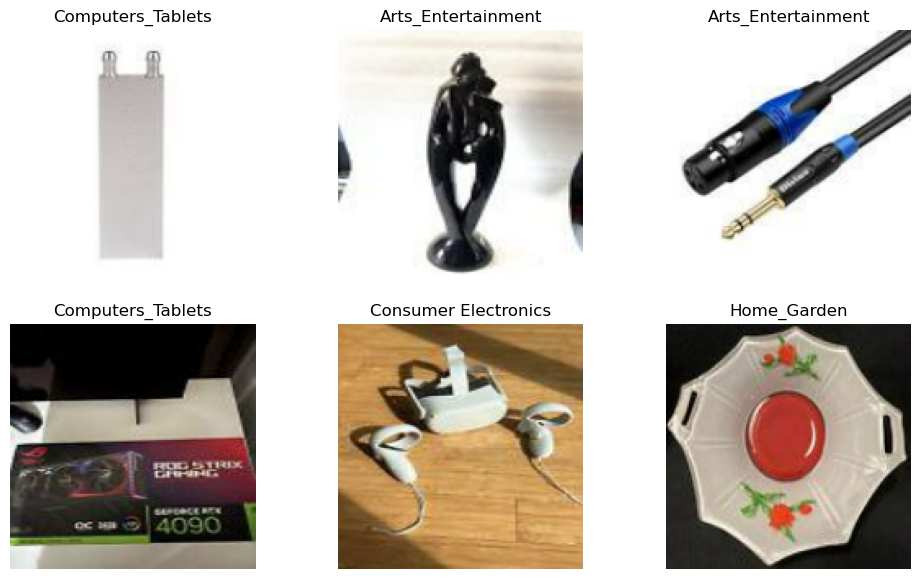

In [8]:
plt.figure(figsize=(12, 7))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
type(train_ds)

tensorflow.python.data.ops.batch_op._BatchDataset

In [10]:
train_ds.cardinality().numpy(), test_ds.cardinality().numpy()

(280, 138)

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 150, 150, 3)
(32,)


In [12]:
#prepare data for modeling with a basic CNN
def augment(image, label):
    image = tf.image.resize(image, [150, 150]) / 255.
#     image = tf.expand_dims(image, axis = 0)
    
    label = tf.reshape(label, [1])
    return image, label

In [13]:
train_aug = train_ds.map(augment)
test_aug = test_ds.map(augment)

In [14]:
train_aug

<_MapDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.int32, name=None))>

In [15]:
train_aug.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.int32, name=None))>

#### Basic Network

In [16]:
# define model architecture
model = Sequential()

model.add(
    Rescaling(
        1./255, 
        input_shape = (150, 150, 3)
    )
)

model.add(
    Conv2D(
        filters = 16,
        kernel_size = (3,3),
        activation = 'relu',
        input_shape = (150, 150, 3)
    )
)

model.add(
    MaxPool2D(
        pool_size = (2,2)
    )
)

model.add(Flatten())

model.add(Dense(
    units = 128,
    activation = 'relu'
))

model.add(Dense(
    units = 1,
    activation = 'sigmoid'
))

In [17]:
# compile
model.compile(loss = 'bce', metrics = ['acc'])

In [46]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 87616)             0         
                                                                 
 dense (Dense)               (None, 128)               11214976  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                        

In [18]:
# fit
history = model.fit(
    train_ds,
    batch_size = 32,
    epochs = 3,
    validation_data = test_ds
)

Epoch 1/3
280/280 [==============================] - 158s 540ms/step - loss: -9091569.0000 - acc: 0.1323 - val_loss: -30831020.0000 - val_acc: 0.1275
Epoch 2/3
280/280 [==============================] - 142s 504ms/step - loss: -90676856.0000 - acc: 0.1328 - val_loss: -179742528.0000 - val_acc: 0.1275
Epoch 3/3
280/280 [==============================] - 148s 525ms/step - loss: -331596832.0000 - acc: 0.1328 - val_loss: -531932768.0000 - val_acc: 0.1275


In [23]:
#Exploring the model
train_preds = model.predict(train_ds)
test_preds = model.predict(test_ds)

138/138 [==============================] - 23s 157ms/step


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


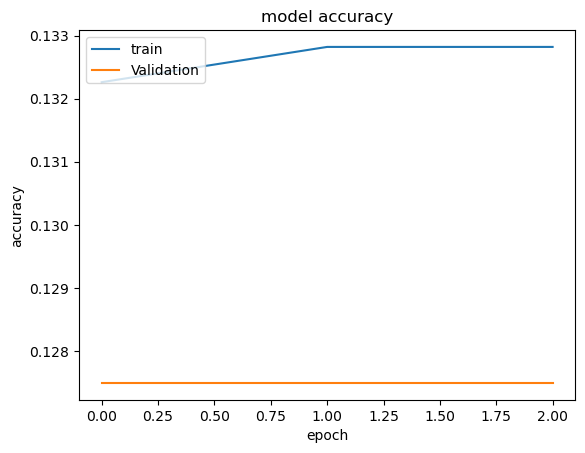

In [24]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

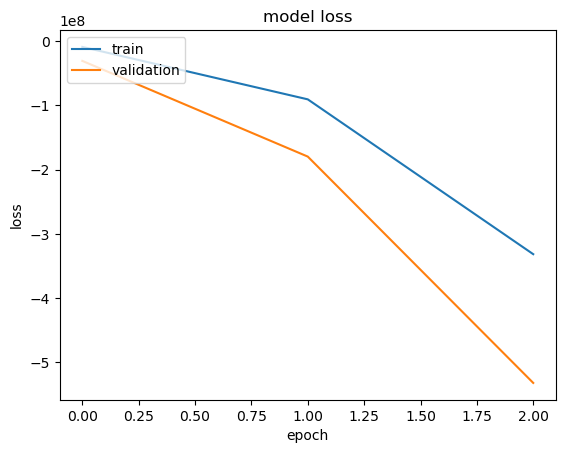

In [25]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

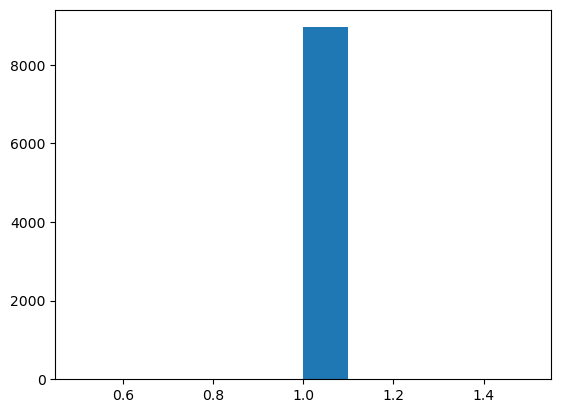

In [26]:
plt.hist(train_preds);

In [27]:
model.save("image_model.h5")

#### Data Augmentation¶

In [28]:
def augment_plus(image, label):
    image = tf.image.resize(image, [150, 150]) / 255.
    image = tf.expand_dims(image, axis = 0)
    
    #augmentation to improve generalization
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_saturation(image, 0, 255.)
    
    image = tfa.image.rotate(image, 20) #don't have to use
    
    label = tf.reshape(label, [1])
    return image, label

In [28]:
train_aug = train_ds.map(augment)
test_aug = test_ds.map(augment)

#### Model 2

In [30]:
# architecture
model_2 = Sequential()

model_2.add(
    Rescaling(
        1./255, 
        input_shape = (150, 150, 3)
    )
)

model_2.add(
    Conv2D(
        filters = 16,
        kernel_size = (3,3),
        activation = 'relu',
        input_shape = (150, 150, 3)
    )
)

model_2.add(
    MaxPool2D(
        pool_size = (2,2)
    )
)

model_2.add(Flatten())

model.add(Dense(
    units = 128,
    activation = 'relu'
))

model_2.add(Dense(
    units = 1,
    activation = 'sigmoid'
))

# compile
model_2.compile(loss = 'bce', metrics = ['acc'])

In [31]:
# fit
history_2 = model_2.fit(
    train_ds,
    batch_size = 32,
    epochs = 3,
    validation_data = test_ds
)

Epoch 1/3
280/280 [==============================] - 142s 476ms/step - loss: -347073.8125 - acc: 0.1328 - val_loss: -976505.7500 - val_acc: 0.1275
Epoch 2/3
280/280 [==============================] - 66s 233ms/step - loss: -2111627.5000 - acc: 0.1328 - val_loss: -3556361.7500 - val_acc: 0.1275
Epoch 3/3
280/280 [==============================] - 69s 240ms/step - loss: -5439308.0000 - acc: 0.1328 - val_loss: -7695011.0000 - val_acc: 0.1275


In [32]:
train_preds_2 = model_2.predict(train_ds)
test_preds_2 = model_2.predict(test_ds)

138/138 [==============================] - 15s 108ms/step


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


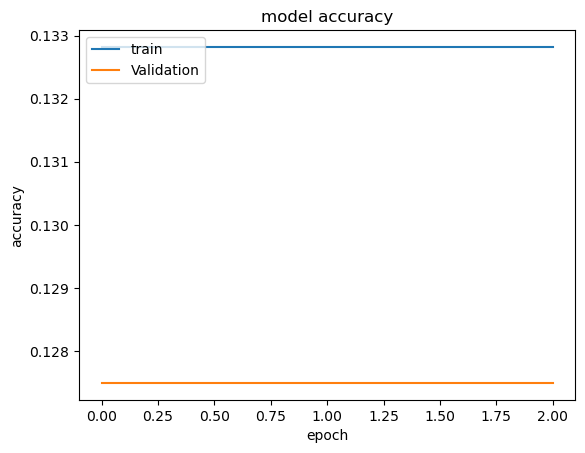

In [33]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history_2.history['acc'])
plt.plot(history_2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

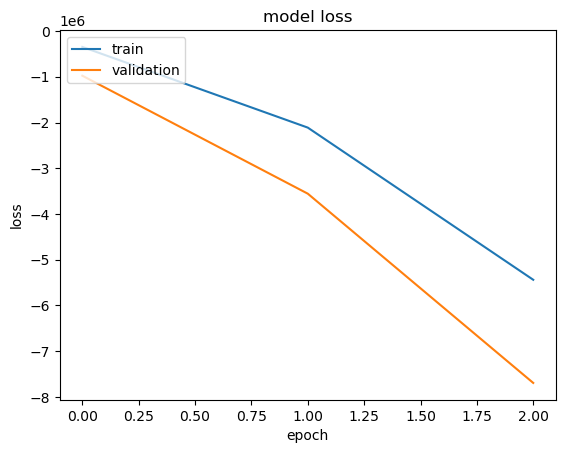

In [34]:
# summarize history for loss
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

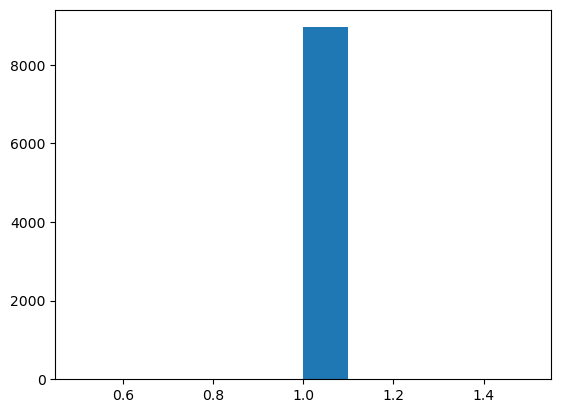

In [36]:
plt.hist(train_preds_2);

In [37]:
model.save("image_model2.h5")

#### EfficientNet

In [38]:
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB7
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [39]:
#Import EfficientNet and freeze¶
eff0 = EfficientNetB0(include_top = False, weights = 'imagenet')

In [40]:
eff0.trainable = False

#### Add EfficientNet to a Sequential model

In [ ]:
#Between EfficientNet and our first Dense layer, we will need to use GlobalAveragePooling2D

In [41]:
model_f0 = Sequential()
model_f0.add(eff0)
model_f0.add(GlobalAveragePooling2D())
model_f0.add(Dense(1, activation = 'sigmoid'))
model_f0.compile(
    optimizer = Adam(learning_rate = 0.001),
    loss = 'bce',
    metrics = ['acc']
)

In [42]:
history_f0 = model_f0.fit(train_ds,
                         validation_data = test_ds,
                         batch_size = 32,
                         epochs = 3
                         )

Epoch 1/3
280/280 [==============================] - 377s 1s/step - loss: -68.1112 - acc: 0.1300 - val_loss: -140.8107 - val_acc: 0.1261
Epoch 2/3
280/280 [==============================] - 356s 1s/step - loss: -205.8736 - acc: 0.1308 - val_loss: -281.6729 - val_acc: 0.1259
Epoch 3/3
280/280 [==============================] - 415s 1s/step - loss: -343.9211 - acc: 0.1315 - val_loss: -423.0521 - val_acc: 0.1259


In [41]:
history_f0.history

{'loss': [-96.91014099121094, -294.99945068359375, -493.1101379394531],
 'acc': [0.11301759630441666, 0.11415565013885498, 0.11406810581684113],
 'val_loss': [-195.10145568847656, -392.2670593261719, -589.5181884765625],
 'val_acc': [0.11268715560436249, 0.11268715560436249, 0.11268715560436249]}

In [42]:
train_preds_f0 = model_f0.predict(train_ds)
test_preds_f0 = model_f0.predict(test_ds)

119/119 [==============================] - 58s 490ms/step


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


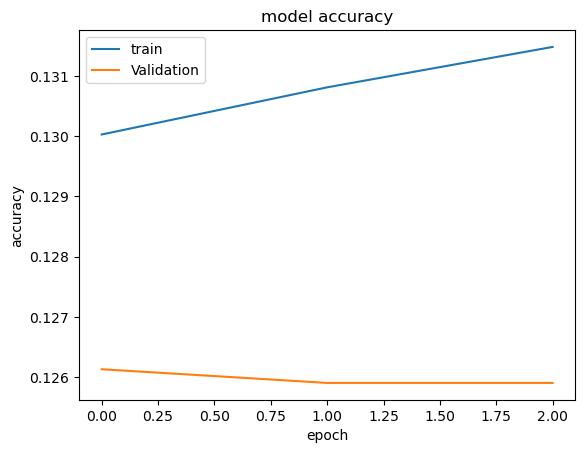

In [43]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history_f0.history['acc'])
plt.plot(history_f0.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

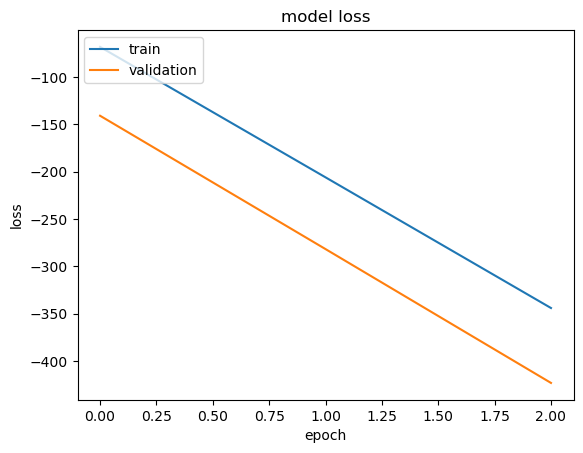

In [44]:
# summarize history for loss
plt.plot(history_f0.history['loss'])
plt.plot(history_f0.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [45]:
plt.hist(train_preds_f0);

NameError: name 'train_preds_f0' is not defined

In [55]:
model.save("image_modelf0.h5")

#### Fine-tune a model

In [44]:
for layer in eff0.layers[20:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

In [45]:
model_ft = Sequential()
model_ft.add(eff0)
model_ft.add(GlobalAveragePooling2D())
model_ft.add(Dense(1, activation='sigmoid'))

In [46]:
model_ft.compile(
    optimizer = Adam(learning_rate = 0.001),
    loss = 'bce',
    metrics = ['acc']
)

In [47]:
history_ft = model_ft.fit(train_ds,
                         validation_data = test_ds,
                         batch_size = 32,
                         epochs = 3
                         )

Epoch 1/3
357/357 [==============================] - 324s 879ms/step - loss: -97.6783 - acc: 0.1129 - val_loss: -196.3619 - val_acc: 0.1129
Epoch 2/3
357/357 [==============================] - 403s 1s/step - loss: -296.3438 - acc: 0.1142 - val_loss: -393.8548 - val_acc: 0.1129
Epoch 3/3
357/357 [==============================] - 334s 935ms/step - loss: -493.9620 - acc: 0.1142 - val_loss: -591.2419 - val_acc: 0.1129


In [48]:
train_preds_ft = model_ft.predict(train_ds)
test_preds_ft = model_ft.predict(test_ds)

119/119 [==============================] - 81s 681ms/step


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


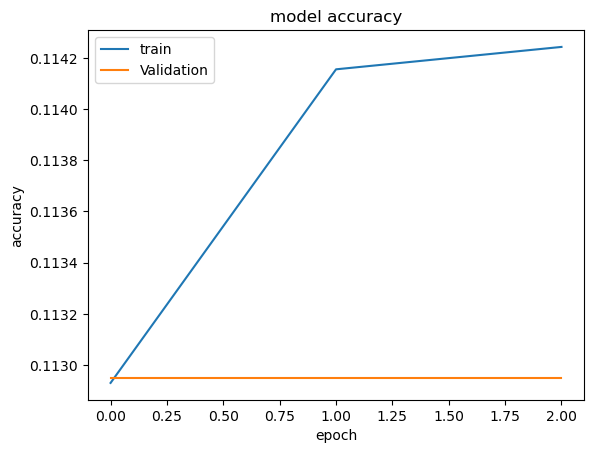

In [65]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history_ft.history['acc'])
plt.plot(history_ft.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

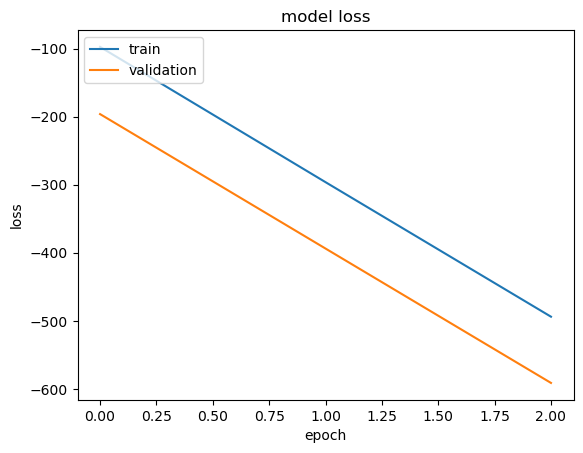

In [64]:
# summarize history for loss
plt.plot(history_ft.history['loss'])
plt.plot(history_ft.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

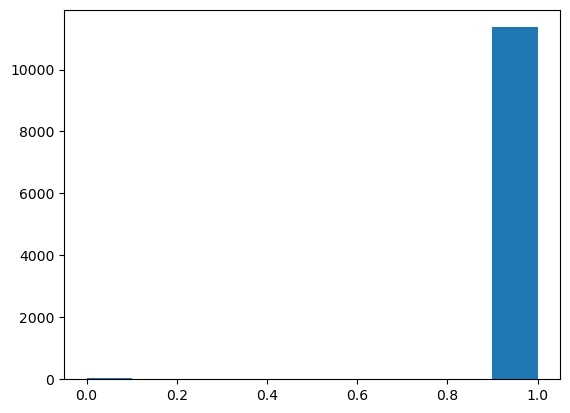

In [49]:
plt.hist(train_preds_ft);

In [50]:
model.save("image_modelft.h5") #import at streamlit app